In [1]:
!pip install pytorch-forecasting pytorch-lightning matplotlib pandas numpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Starting ultra-simple forecasting pipeline...
Loading data from ETTh2.csv
Replacing 17 negative values
Data loaded, shape: (17420, 1)
Date range: 2016-07-01 00:00:00 to 2018-06-26 19:00:00
Target range: 0.0 to 58.87699890136719
Train data shape: (12163, 27)
Validation data shape: (2605, 27)
Test data shape: (2605, 27)


<ipython-input-18-aeb71db8c3e5>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target.loc[df_target['OT'] < 0, 'OT'] = 0.01



Training Linear Regression...
Linear Regression - Validation RMSE: 0.4142, MAE: 0.3098

Training Random Forest...
Random Forest - Validation RMSE: 0.7931, MAE: 0.4057

Training Gradient Boosting...
Gradient Boosting - Validation RMSE: 0.9421, MAE: 0.6295

Best model: Linear Regression (Validation RMSE: 0.4142)
Best model performance on test set:
RMSE: 0.5225
MAE: 0.3801
R²: 0.9960


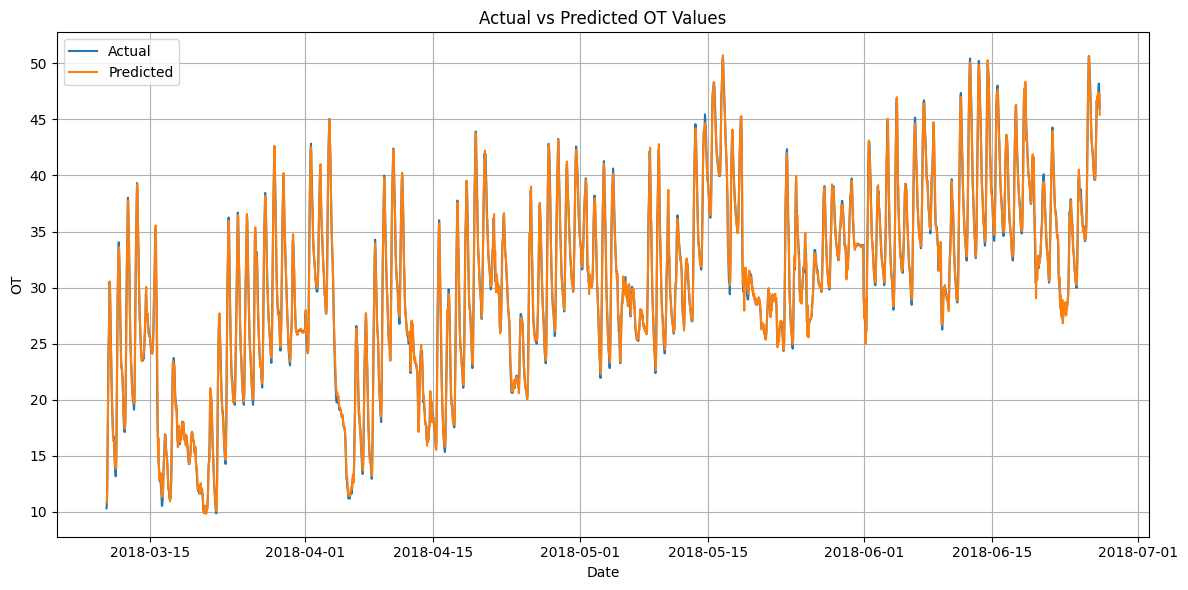

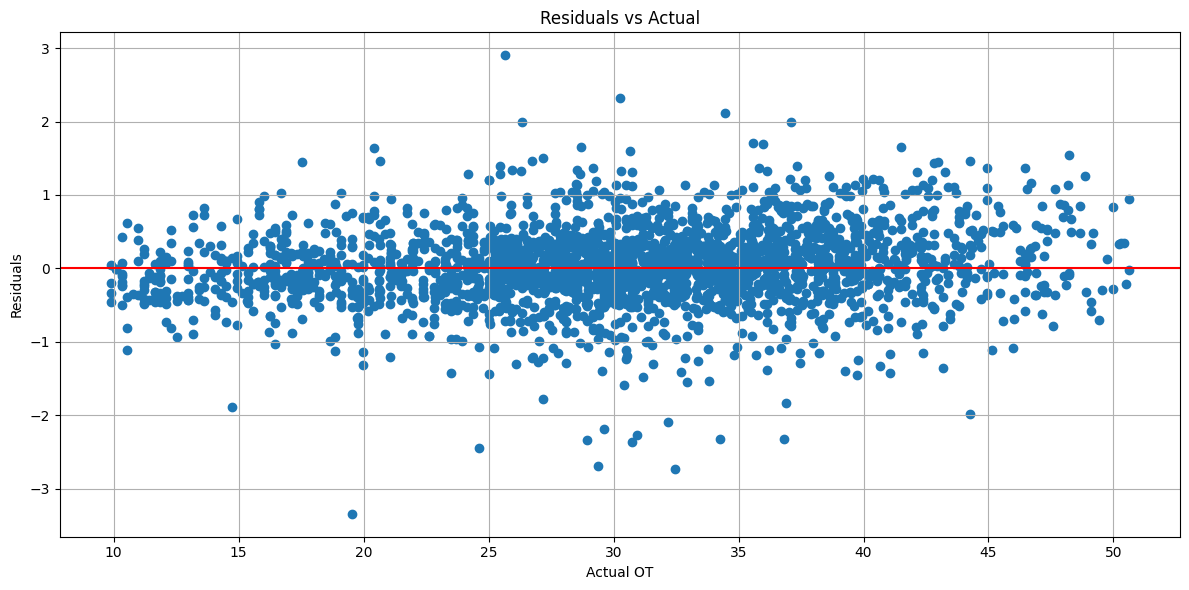

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_data(file_path="ETTh2.csv"):
    """Load and preprocess the ETT dataset."""
    print(f"Loading data from {file_path}")
    # Load data
    df = pd.read_csv(file_path)

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort by date
    df = df.sort_values('date')

    # Set date as index
    df = df.set_index('date')

    # Keep only the target column
    df_target = df[['OT']]

    # Handle negative values
    if (df_target['OT'] < 0).any():
        print(f"Replacing {(df_target['OT'] < 0).sum()} negative values")
        df_target.loc[df_target['OT'] < 0, 'OT'] = 0.01

    # Print summary
    print(f"Data loaded, shape: {df_target.shape}")
    print(f"Date range: {df_target.index.min()} to {df_target.index.max()}")
    print(f"Target range: {df_target['OT'].min()} to {df_target['OT'].max()}")

    return df_target

def create_features(df):
    """Create time-based features."""
    # Copy the dataframe
    df_features = df.copy()

    # Add time-based features
    df_features['hour'] = df_features.index.hour
    df_features['day'] = df_features.index.day
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month

    # Add lag features (past values)
    for lag in [1, 2, 3, 6, 12, 24]:  # Various hourly lags
        df_features[f'lag_{lag}h'] = df_features['OT'].shift(lag)

    # Add rolling statistics
    for window in [6, 12, 24, 48]:  # Various window sizes in hours
        df_features[f'rolling_mean_{window}h'] = df_features['OT'].rolling(window=window).mean()
        df_features[f'rolling_std_{window}h'] = df_features['OT'].rolling(window=window).std()
        df_features[f'rolling_min_{window}h'] = df_features['OT'].rolling(window=window).min()
        df_features[f'rolling_max_{window}h'] = df_features['OT'].rolling(window=window).max()

    # Drop rows with NaN (due to lag/rolling features)
    df_features = df_features.dropna()

    return df_features

def prepare_train_test_data(df_features, forecast_horizon=24, test_size=0.15):
    """Prepare training and testing data."""
    # Define split points
    n = len(df_features)
    test_size_rows = int(n * test_size)
    val_size_rows = int(n * test_size)  # Same size for validation

    # Split data
    train_data = df_features.iloc[:n-test_size_rows-val_size_rows]
    val_data = df_features.iloc[n-test_size_rows-val_size_rows:n-test_size_rows]
    test_data = df_features.iloc[n-test_size_rows:]

    print(f"Train data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Separate features and target
    X_train = train_data.drop('OT', axis=1)
    y_train = train_data['OT']

    X_val = val_data.drop('OT', axis=1)
    y_val = val_data['OT']

    X_test = test_data.drop('OT', axis=1)
    y_test = test_data['OT']

    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test):
    """Train and evaluate different models."""
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression

    results = {}
    best_val_rmse = float('inf')
    best_model = None

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Predict on validation set
        val_pred = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_mae = mean_absolute_error(y_val, val_pred)

        print(f"{name} - Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")

        # Track best model
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model
            best_model_name = name

        # Store results
        results[name] = {
            'model': model,
            'val_rmse': val_rmse,
            'val_mae': val_mae
        }

    print(f"\nBest model: {best_model_name} (Validation RMSE: {best_val_rmse:.4f})")

    # Evaluate best model on test set
    test_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)

    print(f"Best model performance on test set:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, test_pred, label='Predicted')
    plt.title('Actual vs Predicted OT Values')
    plt.xlabel('Date')
    plt.ylabel('OT')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot residuals
    residuals = y_test - test_pred
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residuals vs Actual')
    plt.xlabel('Actual OT')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_model, results

def run_ultra_simple_forecast():
    """Run the complete ultra-simple forecasting pipeline."""
    print("Starting ultra-simple forecasting pipeline...")

    # Load data
    df = load_data("ETTh2.csv")

    # Create features
    df_features = create_features(df)

    # Prepare train/val/test data
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_train_test_data(
        df_features, forecast_horizon=24, test_size=0.15
    )

    # Train and evaluate models
    best_model, results = train_and_evaluate_model(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    return best_model, results

if __name__ == "__main__":
    best_model, results = run_ultra_simple_forecast()

Starting enhanced forecasting pipeline...
Loading data from ETTh2.csv
Replacing 17 negative values
Data loaded, shape: (17420, 1)
Date range: 2016-07-01 00:00:00 to 2018-06-26 19:00:00
Target range: 0.0 to 58.87699890136719
Train data shape: (12079, 42)
Validation data shape: (2587, 42)
Test data shape: (2587, 42)

Training Linear Regression...
Linear Regression - Validation RMSE: 0.4085, MAE: 0.3078, R²: 0.9950

Training Ridge Regression...
Ridge Regression - Validation RMSE: 0.4124, MAE: 0.3107, R²: 0.9949

Training Lasso Regression...


<ipython-input-24-9c87064f1057>:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features[f'pct_change_{period}h'].replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-24-9c87064f1057>:86: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Lasso Regression - Validation RMSE: 0.8946, MAE: 0.7146, R²: 0.9762

Training ElasticNet...
ElasticNet - Validation RMSE: 1.2303, MAE: 1.0080, R²: 0.9549

Training Random Forest...
Random Forest - Validation RMSE: 0.6156, MAE: 0.2486, R²: 0.9887

Training Gradient Boosting...
Gradient Boosting - Validation RMSE: 0.9040, MAE: 0.3618, R²: 0.9757

Best model: Linear Regression (Validation RMSE: 0.4085)
Best model performance on test set:
RMSE: 0.5150
MAE: 0.3777
R²: 0.9961

Calculating feature importance...


<ipython-input-24-9c87064f1057>:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


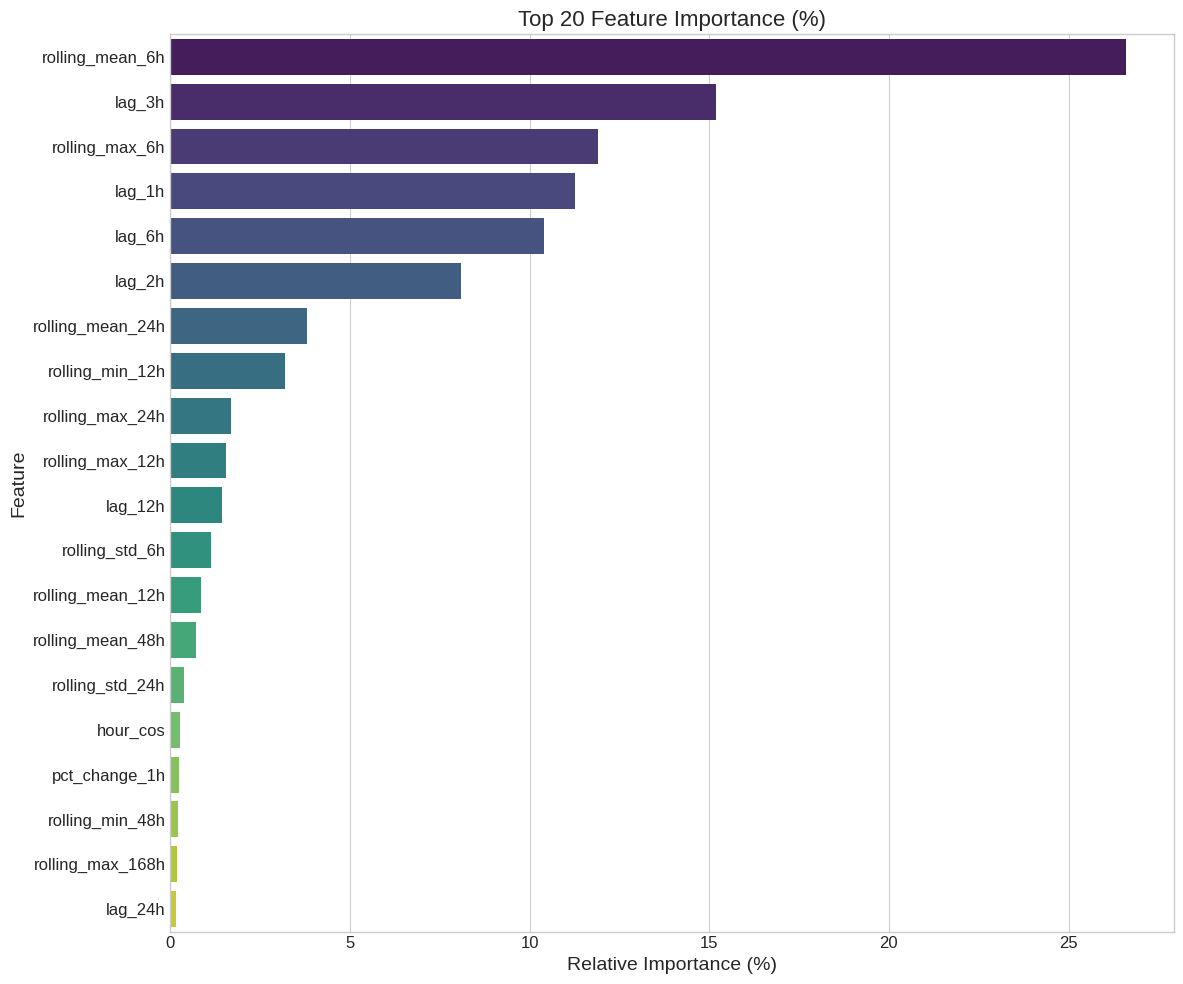

<ipython-input-24-9c87064f1057>:212: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature Type', data=feature_type_df, palette='viridis')


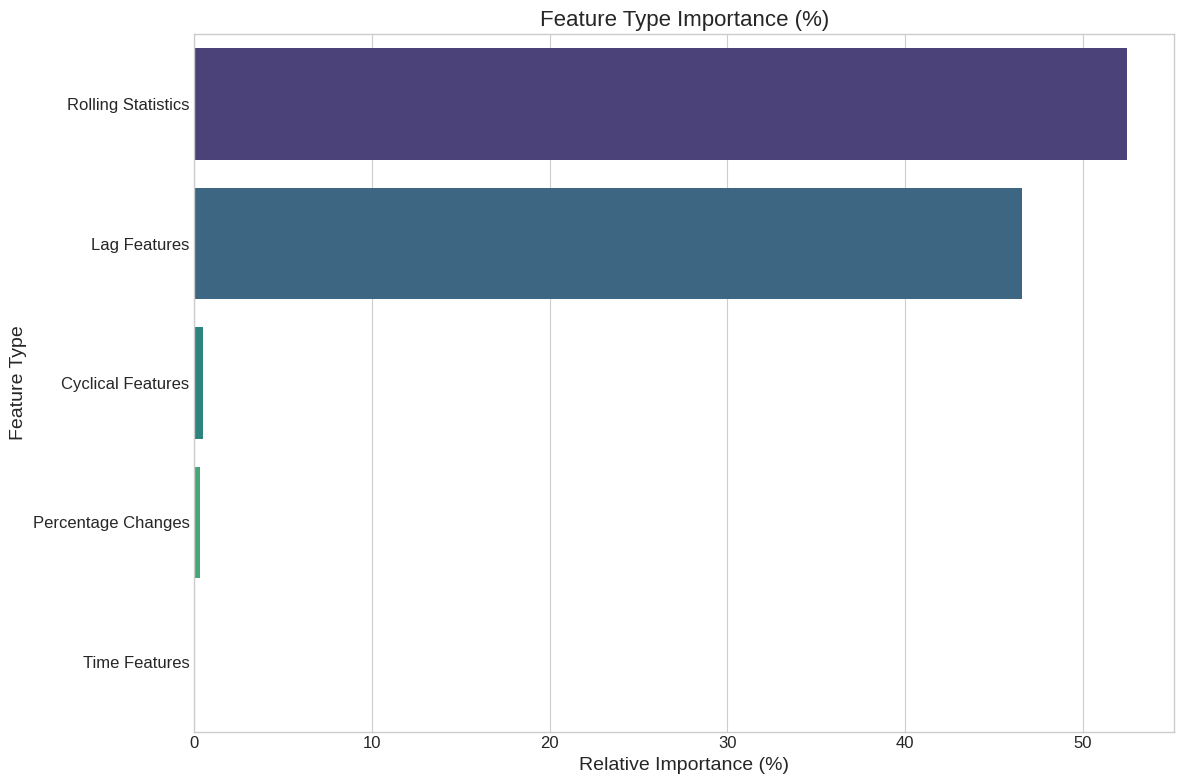

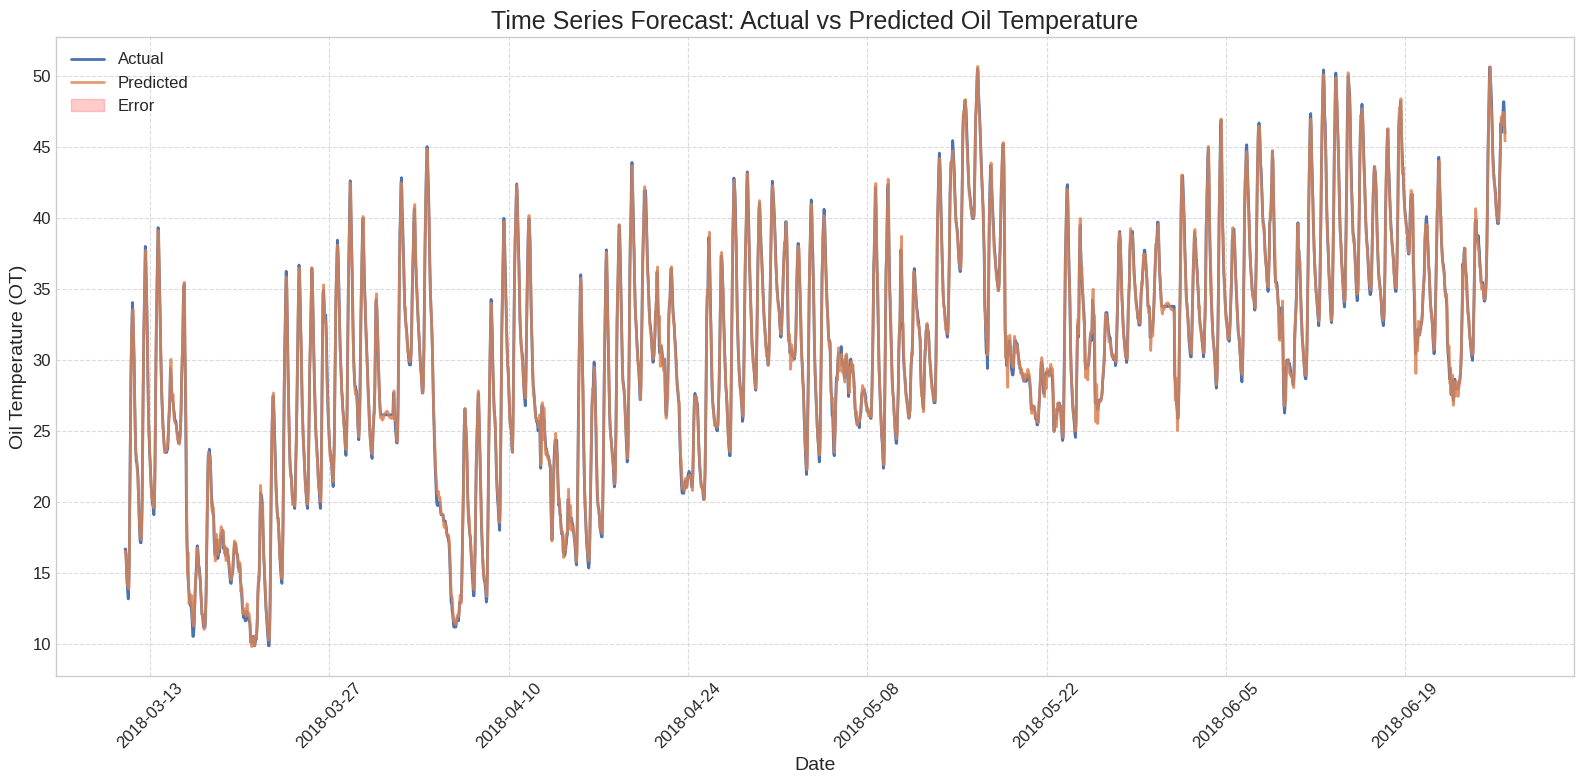

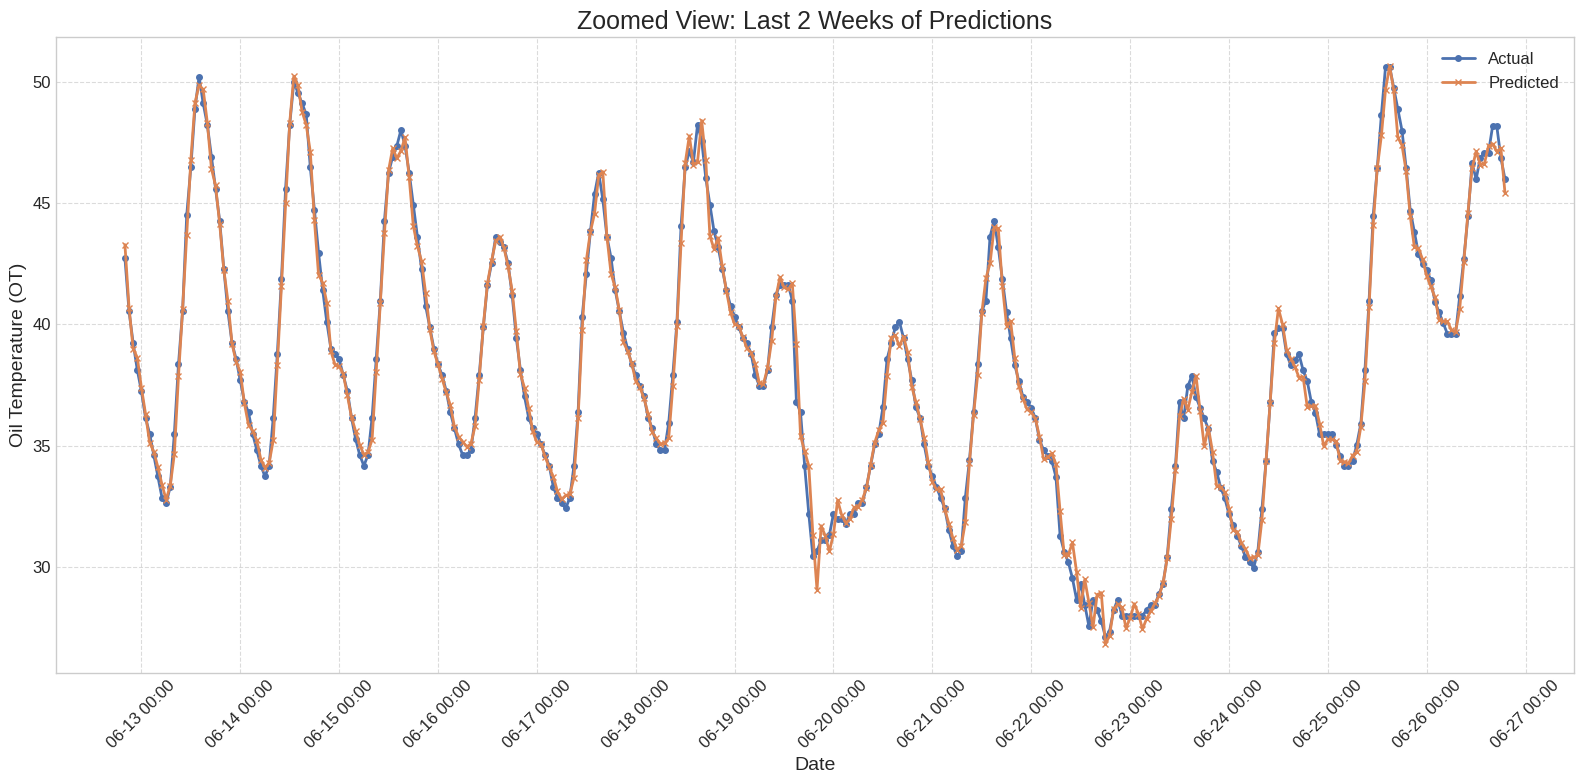

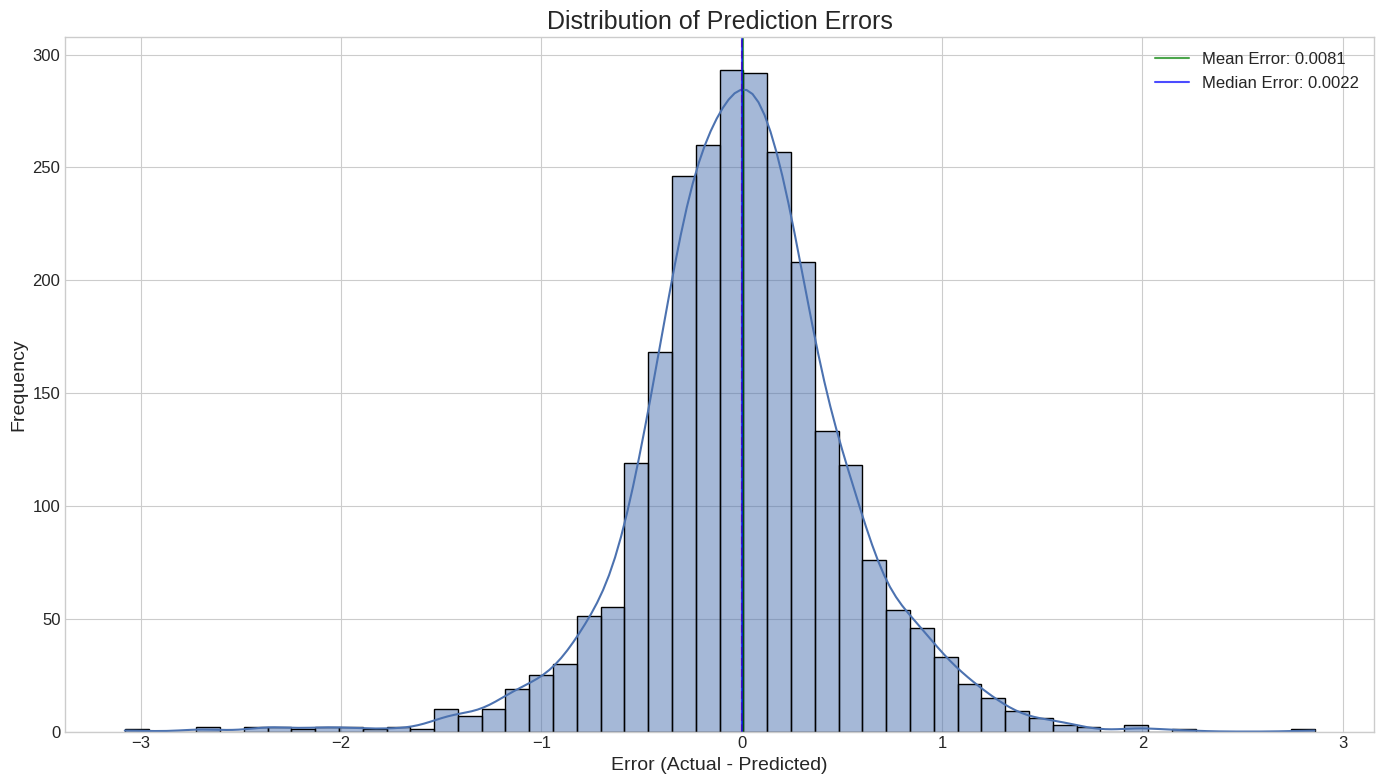

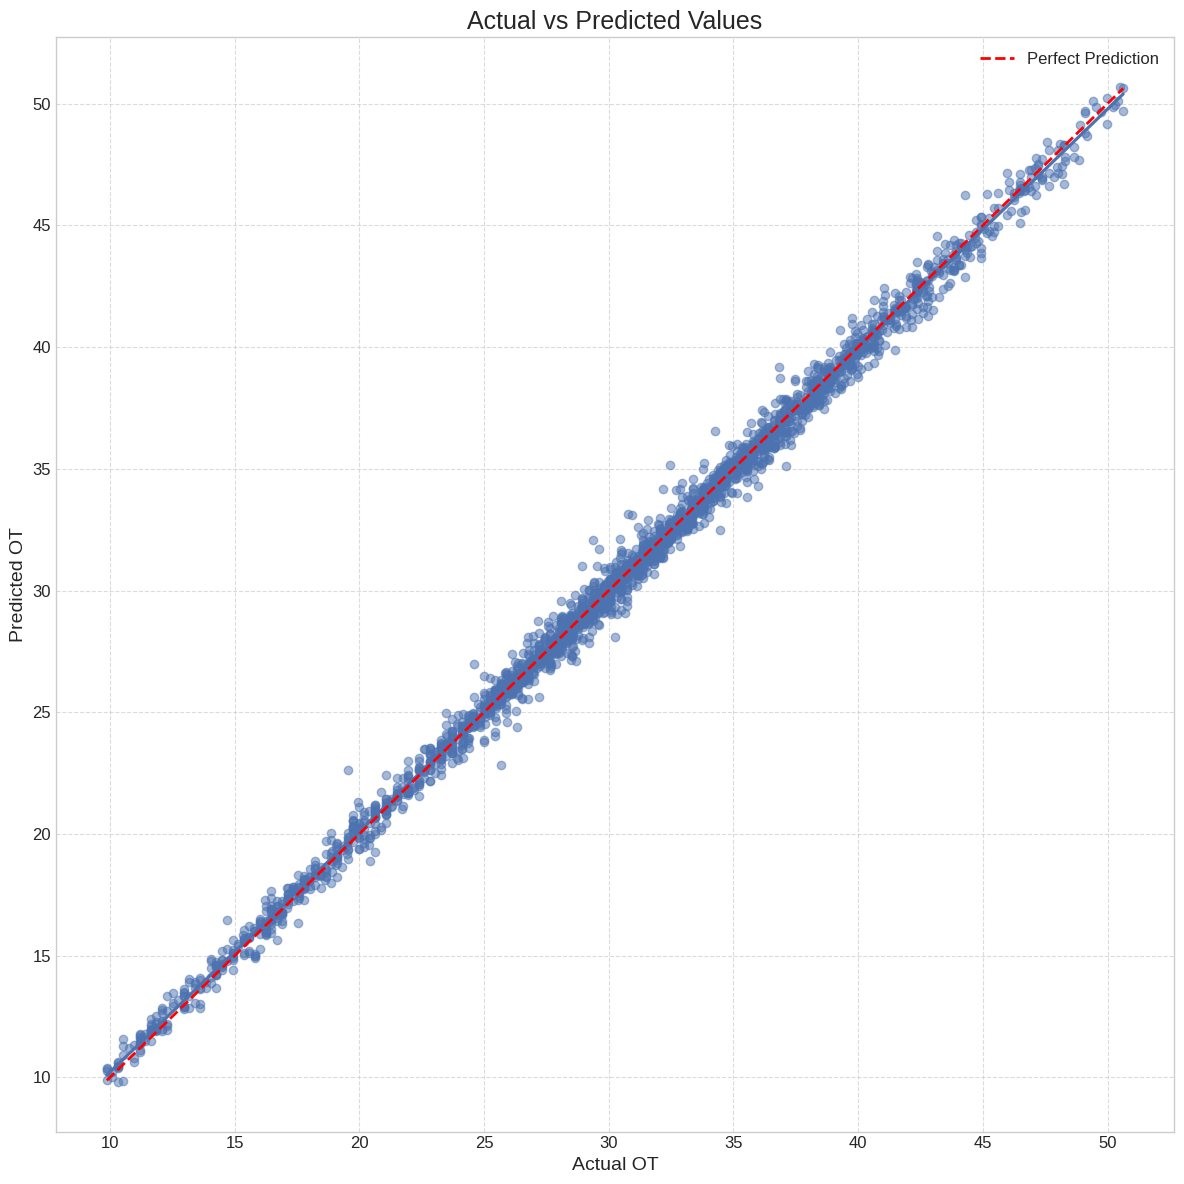

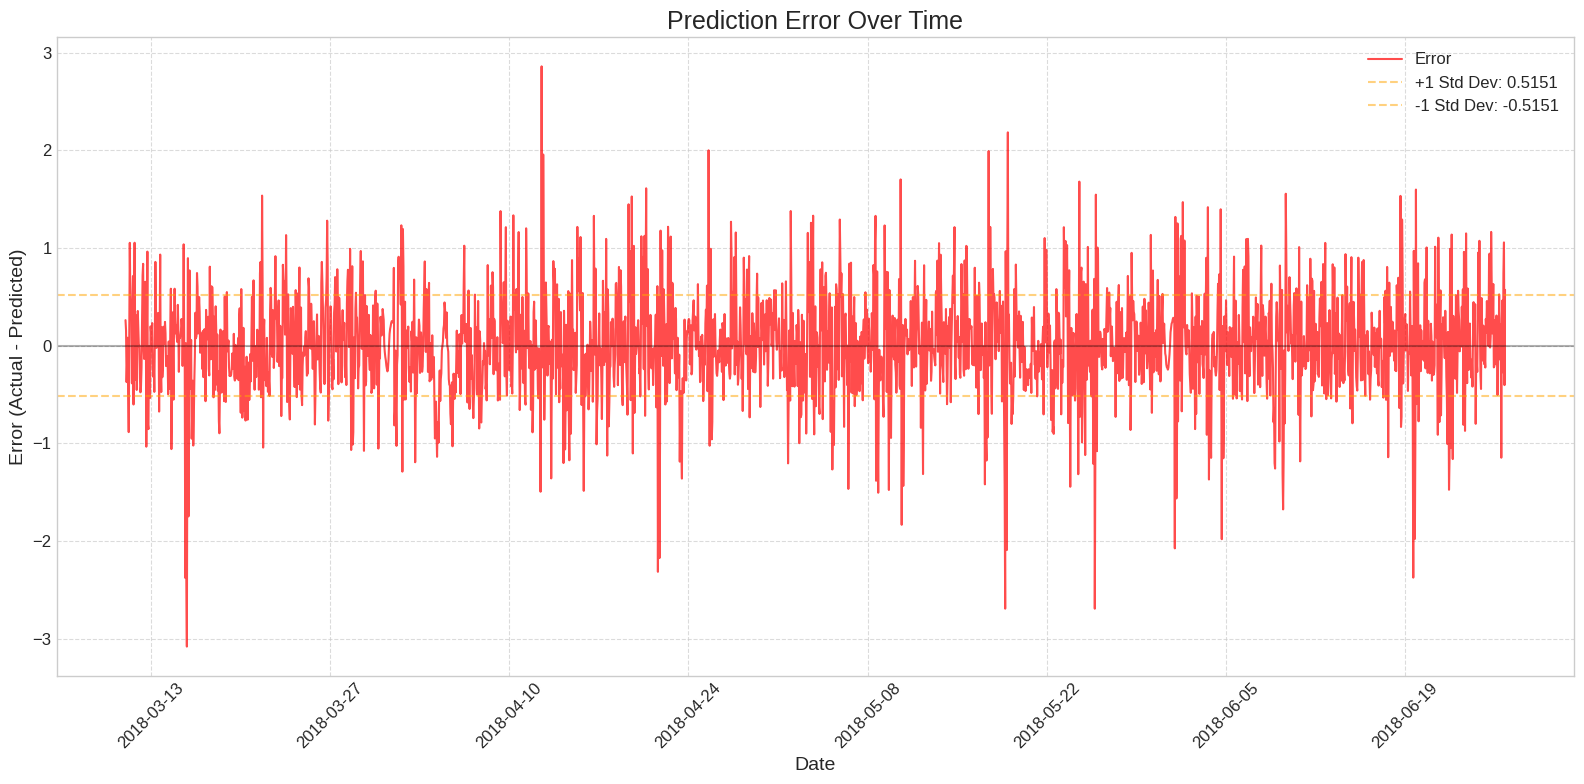

<ipython-input-24-9c87064f1057>:404: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_error.index, y='mean', data=hourly_error, ax=ax, palette='viridis')


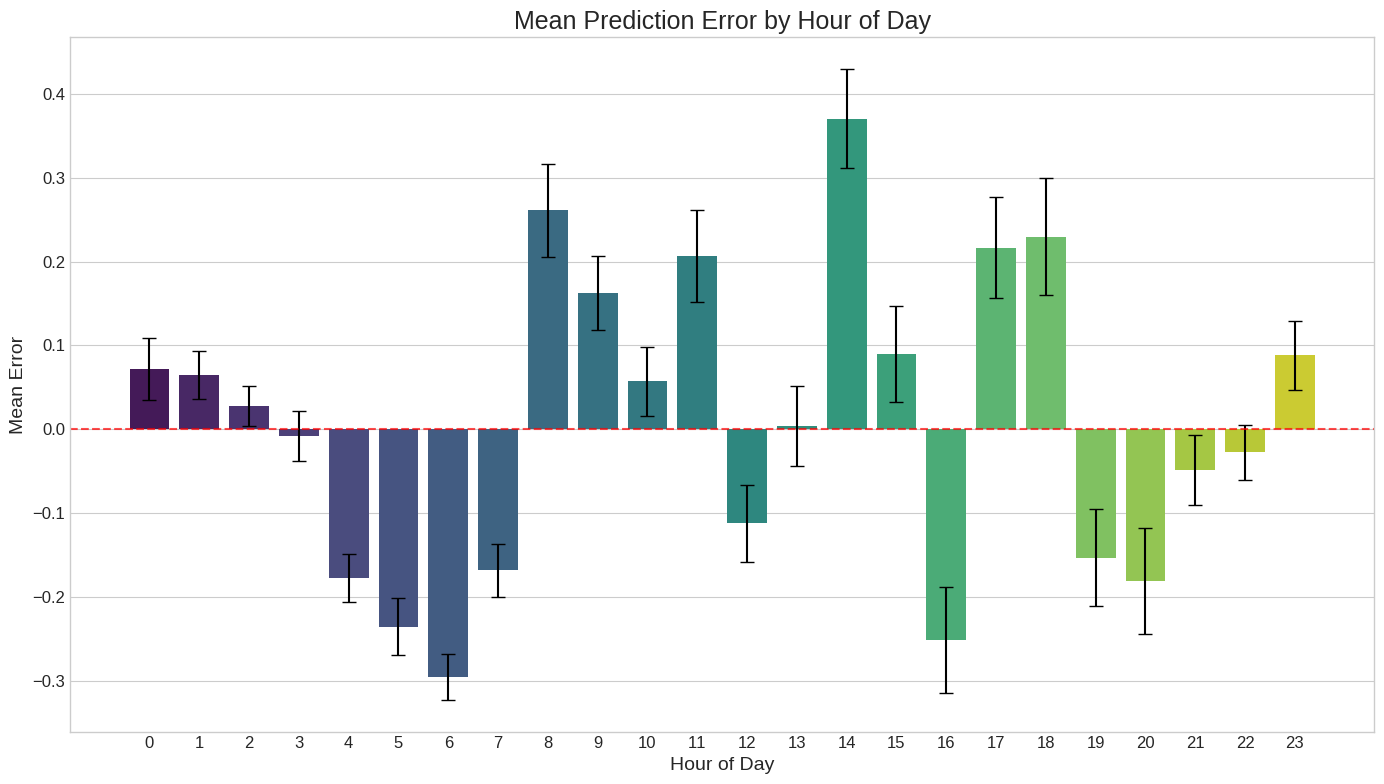

Model saved as best_model.pkl


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import pickle

# Set styles for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def load_data(file_path="ETTh2.csv"):
    """Load and preprocess the ETT dataset."""
    print(f"Loading data from {file_path}")
    # Load data
    df = pd.read_csv(file_path)

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort by date
    df = df.sort_values('date')

    # Set date as index
    df = df.set_index('date')

    # Keep only the target column
    df_target = df[['OT']]

    # Handle negative values
    if (df_target['OT'] < 0).any():
        neg_mask = df_target['OT'] < 0
        print(f"Replacing {neg_mask.sum()} negative values")
        # Use a copy to avoid SettingWithCopyWarning
        df_target = df_target.copy()
        df_target.loc[neg_mask, 'OT'] = 0.01

    # Print summary
    print(f"Data loaded, shape: {df_target.shape}")
    print(f"Date range: {df_target.index.min()} to {df_target.index.max()}")
    print(f"Target range: {df_target['OT'].min()} to {df_target['OT'].max()}")

    return df_target

def create_features(df):
    """Create time-based features."""
    # Copy the dataframe
    df_features = df.copy()

    # Add time-based features
    df_features['hour'] = df_features.index.hour
    df_features['day'] = df_features.index.day
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    # Add seasonal features
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features.index.hour / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features.index.hour / 24)
    df_features['day_of_week_sin'] = np.sin(2 * np.pi * df_features.index.dayofweek / 7)
    df_features['day_of_week_cos'] = np.cos(2 * np.pi * df_features.index.dayofweek / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features.index.month / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features.index.month / 12)

    # Add lag features (past values)
    for lag in [1, 2, 3, 6, 12, 24, 48]:  # Various hourly lags
        df_features[f'lag_{lag}h'] = df_features['OT'].shift(lag)

    # Add rolling statistics
    for window in [6, 12, 24, 48, 168]:  # Various window sizes in hours (up to 1 week)
        df_features[f'rolling_mean_{window}h'] = df_features['OT'].rolling(window=window).mean()
        df_features[f'rolling_std_{window}h'] = df_features['OT'].rolling(window=window).std()
        df_features[f'rolling_min_{window}h'] = df_features['OT'].rolling(window=window).min()
        df_features[f'rolling_max_{window}h'] = df_features['OT'].rolling(window=window).max()

    # Alternative approach
    for period in [1, 6, 12, 24]:
    # Add small epsilon to prevent division by zero
        df_features[f'pct_change_{period}h'] = df_features['OT'].add(1e-8).pct_change(periods=period)
    # Still replace any infinities that might occur
        df_features[f'pct_change_{period}h'].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Fill with a reasonable value
        df_features[f'pct_change_{period}h'].fillna(0, inplace=True)

    # Drop rows with NaN (due to lag/rolling features)
    df_features = df_features.dropna()

    return df_features

def prepare_train_test_data(df_features, forecast_horizon=24, test_size=0.15):
    """Prepare training and testing data."""
    # Define split points
    n = len(df_features)
    test_size_rows = int(n * test_size)
    val_size_rows = int(n * test_size)  # Same size for validation

    # Split data
    train_data = df_features.iloc[:n-test_size_rows-val_size_rows]
    val_data = df_features.iloc[n-test_size_rows-val_size_rows:n-test_size_rows]
    test_data = df_features.iloc[n-test_size_rows:]

    print(f"Train data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Separate features and target
    X_train = train_data.drop('OT', axis=1)
    y_train = train_data['OT']

    X_val = val_data.drop('OT', axis=1)
    y_val = val_data['OT']

    X_test = test_data.drop('OT', axis=1)
    y_test = test_data['OT']

    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

def calculate_feature_importance(model, X, y, feature_names):
    """Calculate and visualize feature importance."""
    print("\nCalculating feature importance...")

    # For linear models, use coefficients
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })

        # Normalize to sum to 100%
        importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100

    # For tree-based models, use feature_importances_
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })

        # Normalize to sum to 100%
        importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100

    # Fallback to permutation importance for other models
    else:
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        importance = result.importances_mean
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })

        # Normalize to sum to 100%
        importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title('Top 20 Feature Importance (%)', fontsize=16)
    plt.xlabel('Relative Importance (%)', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Group features by type
    feature_types = {}

    for feature in importance_df['Feature']:
        if 'lag' in feature:
            feature_type = 'Lag Features'
        elif 'rolling' in feature:
            feature_type = 'Rolling Statistics'
        elif 'pct_change' in feature:
            feature_type = 'Percentage Changes'
        elif any(x in feature for x in ['sin', 'cos']):
            feature_type = 'Cyclical Features'
        else:
            feature_type = 'Time Features'

        if feature_type not in feature_types:
            feature_types[feature_type] = 0

        # Add the importance value
        idx = importance_df[importance_df['Feature'] == feature].index[0]
        feature_types[feature_type] += importance_df.loc[idx, 'Importance']

    # Create a DataFrame for feature type importance
    feature_type_df = pd.DataFrame({
        'Feature Type': list(feature_types.keys()),
        'Importance': list(feature_types.values())
    }).sort_values('Importance', ascending=False)

    # Plot feature type importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature Type', data=feature_type_df, palette='viridis')
    plt.title('Feature Type Importance (%)', fontsize=16)
    plt.xlabel('Relative Importance (%)', fontsize=14)
    plt.ylabel('Feature Type', fontsize=14)
    plt.tight_layout()
    plt.show()

    return importance_df, feature_type_df

def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test):
    """Train and evaluate different models."""
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

    results = {}
    best_val_rmse = float('inf')
    best_model = None

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=42),
        'Lasso Regression': Lasso(alpha=0.1, random_state=42),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Predict on validation set
        val_pred = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_mae = mean_absolute_error(y_val, val_pred)
        val_r2 = r2_score(y_val, val_pred)

        print(f"{name} - Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")

        # Track best model
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model
            best_model_name = name

        # Store results
        results[name] = {
            'model': model,
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_r2': val_r2
        }

    print(f"\nBest model: {best_model_name} (Validation RMSE: {best_val_rmse:.4f})")

    # Evaluate best model on test set
    test_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)

    print(f"Best model performance on test set:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")

    # Calculate feature importance
    feature_imp, feature_type_imp = calculate_feature_importance(best_model, X_test, y_test, X_test.columns)

    return best_model, results, test_pred, (feature_imp, feature_type_imp)

def plot_enhanced_visualizations(y_test, test_pred):
    """Create enhanced visualizations for model evaluation."""
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': test_pred,
        'Error': y_test - test_pred,
        'Abs_Error': np.abs(y_test - test_pred),
        'Squared_Error': (y_test - test_pred) ** 2
    })

    # Plot 1: Time series of actual vs predicted
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(plot_df.index, plot_df['Actual'], label='Actual', linewidth=2)
    ax.plot(plot_df.index, plot_df['Predicted'], label='Predicted', linewidth=2, alpha=0.8)

    # Highlight the error area
    ax.fill_between(plot_df.index, plot_df['Actual'], plot_df['Predicted'],
                     color='red', alpha=0.2, label='Error')

    # Format the plot
    ax.set_title('Time Series Forecast: Actual vs Predicted Oil Temperature', fontsize=18)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Oil Temperature (OT)', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.xticks(rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot 2: Zoomed in view of a sample period (last 2 weeks)
    sample_period = plot_df.iloc[-336:].copy()  # Last 2 weeks (14 days * 24 hours)

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(sample_period.index, sample_period['Actual'], label='Actual', marker='o', markersize=4, linewidth=2)
    ax.plot(sample_period.index, sample_period['Predicted'], label='Predicted', marker='x', markersize=4, linewidth=2)

    # Format the plot
    ax.set_title('Zoomed View: Last 2 Weeks of Predictions', fontsize=18)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Oil Temperature (OT)', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot 3: Error distribution
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(plot_df['Error'], kde=True, ax=ax, bins=50)
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.7)

    # Get error statistics
    mean_error = plot_df['Error'].mean()
    median_error = plot_df['Error'].median()
    std_error = plot_df['Error'].std()

    # Add error statistics to plot
    ax.axvline(x=mean_error, color='g', linestyle='-', alpha=0.7,
               label=f'Mean Error: {mean_error:.4f}')
    ax.axvline(x=median_error, color='b', linestyle='-', alpha=0.7,
              label=f'Median Error: {median_error:.4f}')

    # Format the plot
    ax.set_title('Distribution of Prediction Errors', fontsize=18)
    ax.set_xlabel('Error (Actual - Predicted)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot 4: Scatter plot with regression line
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.regplot(x='Actual', y='Predicted', data=plot_df, scatter_kws={'alpha':0.5}, ax=ax)

    # Add perfect prediction line
    ax.plot([plot_df['Actual'].min(), plot_df['Actual'].max()],
           [plot_df['Actual'].min(), plot_df['Actual'].max()],
           'r--', linewidth=2, label='Perfect Prediction')

    # Format the plot
    ax.set_title('Actual vs Predicted Values', fontsize=18)
    ax.set_xlabel('Actual OT', fontsize=14)
    ax.set_ylabel('Predicted OT', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot 5: Error over time (to check for patterns)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(plot_df.index, plot_df['Error'], label='Error', color='red', alpha=0.7)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Add error bands
    ax.axhline(y=std_error, color='orange', linestyle='--', alpha=0.5, label=f'+1 Std Dev: {std_error:.4f}')
    ax.axhline(y=-std_error, color='orange', linestyle='--', alpha=0.5, label=f'-1 Std Dev: {-std_error:.4f}')

    # Format the plot
    ax.set_title('Prediction Error Over Time', fontsize=18)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Error (Actual - Predicted)', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.xticks(rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot 6: Error by hour of day (to check for daily patterns)
    plot_df['hour'] = plot_df.index.hour
    hourly_error = plot_df.groupby('hour')['Error'].agg(['mean', 'std', 'count'])

    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(x=hourly_error.index, y='mean', data=hourly_error, ax=ax, palette='viridis')

    # Add error bars
    ax.errorbar(x=range(len(hourly_error)), y=hourly_error['mean'],
                yerr=hourly_error['std'] / np.sqrt(hourly_error['count']),
                fmt='none', color='black', capsize=5, label='95% CI')

    # Format the plot
    ax.set_title('Mean Prediction Error by Hour of Day', fontsize=18)
    ax.set_xlabel('Hour of Day', fontsize=14)
    ax.set_ylabel('Mean Error', fontsize=14)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def run_enhanced_forecast():
    """Run the enhanced forecasting pipeline."""
    print("Starting enhanced forecasting pipeline...")

    # Load data
    df = load_data("ETTh2.csv")

    # Create features
    df_features = create_features(df)

    # Prepare train/val/test data
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_train_test_data(
        df_features, forecast_horizon=24, test_size=0.15
    )

    # Train and evaluate models
    best_model, results, test_pred, feature_importance = train_and_evaluate_model(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    # Create enhanced visualizations
    plot_enhanced_visualizations(y_test, test_pred)

    return best_model, results, feature_importance

if __name__ == "__main__":
    best_model, results, feature_importance = run_enhanced_forecast()

    # Save the trained model immediately after it's created
    import pickle
    with open("best_model.pkl", 'wb') as f:
        pickle.dump(best_model, f)

    print("Model saved as best_model.pkl")  # Optional confirmation message


Model loaded from best_model.pkl

Oil Temperature Prediction Options:
1. Predict for a random day
2. Predict for a specific date
Enter your choice (1 or 2): 2
Enter date in YYYY-MM-DD format: 2016-07-18
Enter number of hours to use as input (default 6): 10
Loading data from ETTh1.csv
Replacing 154 negative values
Data loaded, shape: (17420, 1)
Date range: 2016-07-01 00:00:00 to 2018-06-26 19:00:00
Target range: 0.0 to 46.00699996948242
Using specified date: 2016-07-18
Forecast metrics:
RMSE: 15.7608
MAE: 12.2166


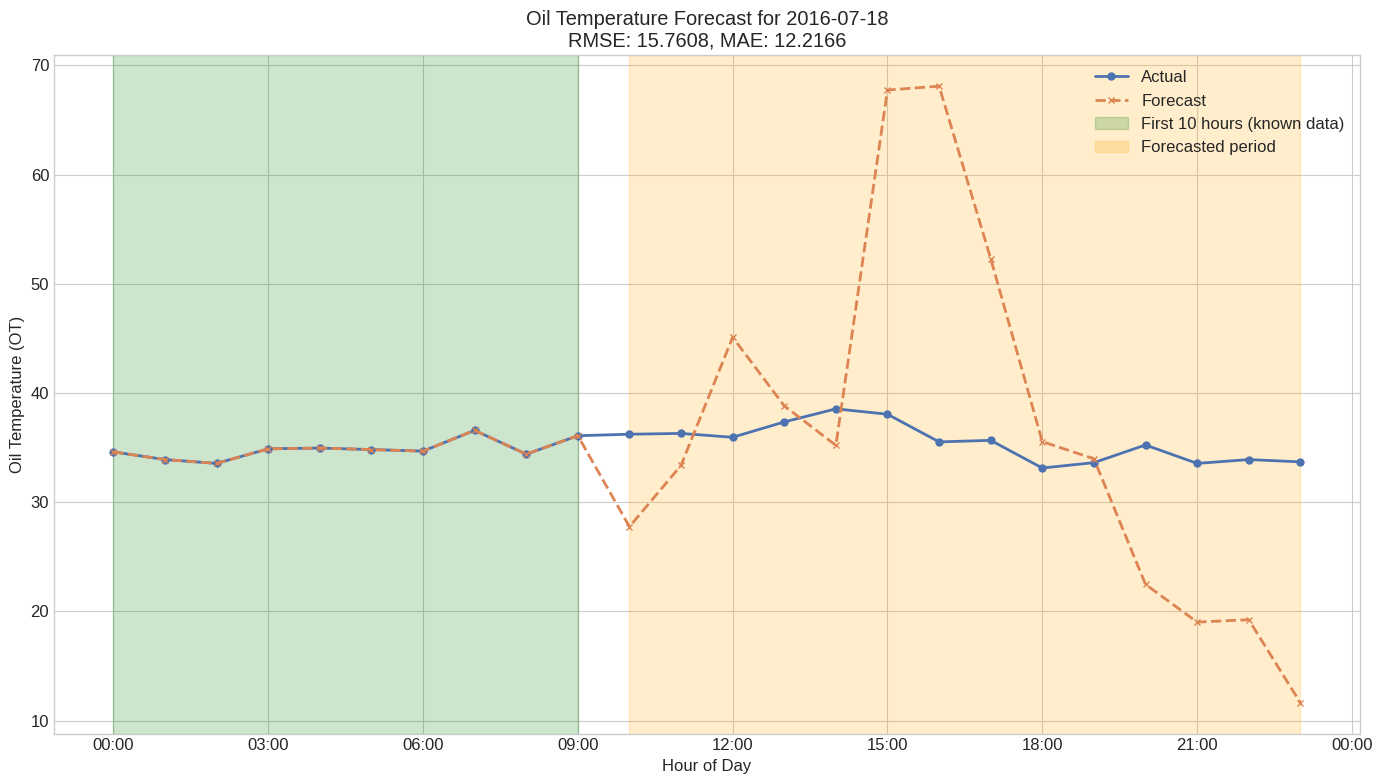

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import random
import datetime

# First, ensure you've saved your best model after training it with ETTh2.csv
# best_model, results, feature_importance = run_enhanced_forecast()
# save_model(best_model, "best_model.pkl")

def load_data(file_path):
    """Load and preprocess the ETT dataset."""
    print(f"Loading data from {file_path}")
    # Load data
    df = pd.read_csv(file_path)

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort by date
    df = df.sort_values('date')

    # Set date as index
    df = df.set_index('date')

    # Keep only the target column
    df_target = df[['OT']]

    # Handle negative values
    if (df_target['OT'] < 0).any():
        neg_mask = df_target['OT'] < 0
        print(f"Replacing {neg_mask.sum()} negative values")
        # Use a copy to avoid SettingWithCopyWarning
        df_target = df_target.copy()
        df_target.loc[neg_mask, 'OT'] = 0.01

    # Print summary
    print(f"Data loaded, shape: {df_target.shape}")
    print(f"Date range: {df_target.index.min()} to {df_target.index.max()}")
    print(f"Target range: {df_target['OT'].min()} to {df_target['OT'].max()}")

    return df_target

def create_features(df):
    """Create time-based features."""
    # Copy the dataframe
    df_features = df.copy()

    # Add time-based features
    df_features['hour'] = df_features.index.hour
    df_features['day'] = df_features.index.day
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    # Add seasonal features
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features.index.hour / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features.index.hour / 24)
    df_features['day_of_week_sin'] = np.sin(2 * np.pi * df_features.index.dayofweek / 7)
    df_features['day_of_week_cos'] = np.cos(2 * np.pi * df_features.index.dayofweek / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features.index.month / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features.index.month / 12)

    # Add lag features (past values)
    for lag in [1, 2, 3, 6, 12, 24, 48]:  # Various hourly lags
        df_features[f'lag_{lag}h'] = df_features['OT'].shift(lag)

    # Add rolling statistics
    for window in [6, 12, 24, 48, 168]:  # Various window sizes in hours (up to 1 week)
        df_features[f'rolling_mean_{window}h'] = df_features['OT'].rolling(window=window).mean()
        df_features[f'rolling_std_{window}h'] = df_features['OT'].rolling(window=window).std()
        df_features[f'rolling_min_{window}h'] = df_features['OT'].rolling(window=window).min()
        df_features[f'rolling_max_{window}h'] = df_features['OT'].rolling(window=window).max()

    # Add percentage changes (momentum features) - FIXED VERSION
    for period in [1, 6, 12, 24]:
        pct_change = df_features['OT'].pct_change(periods=period)
        # Replace inf and -inf with NaN, then fill with a reasonable value
        pct_change = pct_change.replace([np.inf, -np.inf], np.nan)
        # You can either drop these rows, or replace with a large finite value
        max_change = pct_change.dropna().abs().quantile(0.99)  # 99th percentile as cap
        pct_change = pct_change.fillna(max_change)
        df_features[f'pct_change_{period}h'] = pct_change

    # Drop rows with NaN (due to lag/rolling features)
    df_features = df_features.dropna()

    return df_features

def load_model(file_path="best_model.pkl"):
    """Load the trained model from a file."""
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {file_path}")
    return model

def predict_random_day(model, data_path="ETTh1.csv", hours_to_use=6):
    """
    Predict oil temperature for a random day from the dataset.
    """
    # Load new data
    df_new = load_data(data_path)

    # Create features for the new data
    df_features_new = create_features(df_new)

    # Get a list of unique dates
    unique_dates = np.unique(df_features_new.index.date)

    # Select a random date
    selected_date = random.choice(unique_dates)
    print(f"Randomly selected date: {selected_date}")

    # Get data for the entire day
    day_data = df_features_new[df_features_new.index.date == selected_date].copy()

    # Initialize scaler
    scaler = StandardScaler()

    # Fit scaler on the entire day's data (this is just for consistency)
    X_day_full = day_data.drop('OT', axis=1)
    scaler.fit(X_day_full)

    # Get the first few hours as input
    known_data = day_data.iloc[:hours_to_use].copy()

    # Create results dataframe
    results_df = pd.DataFrame({
        'Actual': day_data['OT'],
        'Forecast': np.nan
    })

    # Add known values to forecast column
    results_df.loc[known_data.index, 'Forecast'] = known_data['OT']

    # Prepare to forecast rest of the day
    current_data = known_data.copy()

    # For each remaining hour in the day
    for i in range(hours_to_use, len(day_data)):
        # Get the timestamp for the next hour to predict
        next_timestamp = day_data.index[i]

        # Extract features for the latest data we have
        X_current = current_data.drop('OT', axis=1)
        X_current_scaled = scaler.transform(X_current)
        X_current_scaled = pd.DataFrame(X_current_scaled, index=X_current.index, columns=X_current.columns)

        # Use the latest hour's features as input
        latest_features = X_current_scaled.iloc[-1:]

        # Make a prediction
        next_prediction = model.predict(latest_features)[0]

        # Store the prediction
        results_df.loc[next_timestamp, 'Forecast'] = next_prediction

        # Create a new row with the predicted value
        new_row = day_data.loc[next_timestamp].copy()
        new_row['OT'] = next_prediction

        # Add this row to our current data (for next iteration)
        current_data = pd.concat([current_data, pd.DataFrame([new_row])])

    # Calculate error metrics for the forecasted period
    forecast_errors = results_df.iloc[hours_to_use:].dropna()
    mse = ((forecast_errors['Actual'] - forecast_errors['Forecast'])**2).mean()
    rmse = np.sqrt(mse)
    mae = (forecast_errors['Actual'] - forecast_errors['Forecast']).abs().mean()

    print(f"Forecast metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Plot the results
    plt.figure(figsize=(14, 8))
    plt.plot(results_df.index, results_df['Actual'], label='Actual', linewidth=2, marker='o', markersize=5)
    plt.plot(results_df.index, results_df['Forecast'], label='Forecast', linewidth=2, linestyle='--', marker='x', markersize=5)

    # Format x-axis to show hours
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Highlight the known data area
    plt.axvspan(day_data.index[0], day_data.index[hours_to_use-1], color='green', alpha=0.2,
                label=f'First {hours_to_use} hours (known data)')

    # Highlight the forecasted area
    plt.axvspan(day_data.index[hours_to_use], day_data.index[-1], color='orange', alpha=0.2,
                label='Forecasted period')

    plt.title(f'Oil Temperature Forecast for {selected_date}\nRMSE: {rmse:.4f}, MAE: {mae:.4f}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Oil Temperature (OT)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df, selected_date

def predict_specific_day(model, data_path="ETTh1.csv", specific_date="2017-07-01", hours_to_use=6):
    """
    Predict oil temperature for a specific day from the dataset.
    """
    # Load new data
    df_new = load_data(data_path)

    # Create features for the new data
    df_features_new = create_features(df_new)

    # Parse the specific date
    selected_date = pd.to_datetime(specific_date).date()
    print(f"Using specified date: {selected_date}")

    # Get data for the entire day
    day_data = df_features_new[df_features_new.index.date == selected_date].copy()

    if len(day_data) == 0:
        print(f"No data available for date: {selected_date}")
        return None

    # Initialize scaler
    scaler = StandardScaler()

    # Fit scaler on the entire day's data (this is just for consistency)
    X_day_full = day_data.drop('OT', axis=1)
    scaler.fit(X_day_full)

    # Get the first few hours as input
    known_data = day_data.iloc[:hours_to_use].copy()

    # Create results dataframe
    results_df = pd.DataFrame({
        'Actual': day_data['OT'],
        'Forecast': np.nan
    })

    # Add known values to forecast column
    results_df.loc[known_data.index, 'Forecast'] = known_data['OT']

    # Prepare to forecast rest of the day
    current_data = known_data.copy()

    # For each remaining hour in the day
    for i in range(hours_to_use, len(day_data)):
        # Get the timestamp for the next hour to predict
        next_timestamp = day_data.index[i]

        # Extract features for the latest data we have
        X_current = current_data.drop('OT', axis=1)
        X_current_scaled = scaler.transform(X_current)
        X_current_scaled = pd.DataFrame(X_current_scaled, index=X_current.index, columns=X_current.columns)

        # Use the latest hour's features as input
        latest_features = X_current_scaled.iloc[-1:]

        # Make a prediction
        next_prediction = model.predict(latest_features)[0]

        # Store the prediction
        results_df.loc[next_timestamp, 'Forecast'] = next_prediction

        # Create a new row with the predicted value
        new_row = day_data.loc[next_timestamp].copy()
        new_row['OT'] = next_prediction

        # Add this row to our current data (for next iteration)
        current_data = pd.concat([current_data, pd.DataFrame([new_row])])

    # Calculate error metrics for the forecasted period
    forecast_errors = results_df.iloc[hours_to_use:].dropna()
    mse = ((forecast_errors['Actual'] - forecast_errors['Forecast'])**2).mean()
    rmse = np.sqrt(mse)
    mae = (forecast_errors['Actual'] - forecast_errors['Forecast']).abs().mean()

    print(f"Forecast metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Plot the results
    plt.figure(figsize=(14, 8))
    plt.plot(results_df.index, results_df['Actual'], label='Actual', linewidth=2, marker='o', markersize=5)
    plt.plot(results_df.index, results_df['Forecast'], label='Forecast', linewidth=2, linestyle='--', marker='x', markersize=5)

    # Format x-axis to show hours
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Highlight the known data area
    plt.axvspan(day_data.index[0], day_data.index[hours_to_use-1], color='green', alpha=0.2,
                label=f'First {hours_to_use} hours (known data)')

    # Highlight the forecasted area
    plt.axvspan(day_data.index[hours_to_use], day_data.index[-1], color='orange', alpha=0.2,
                label='Forecasted period')

    plt.title(f'Oil Temperature Forecast for {selected_date}\nRMSE: {rmse:.4f}, MAE: {mae:.4f}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Oil Temperature (OT)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df

# Main execution
if __name__ == "__main__":
    # Load the previously trained model
    model = load_model("best_model.pkl")

    # Ask user for prediction type
    print("\nOil Temperature Prediction Options:")
    print("1. Predict for a random day")
    print("2. Predict for a specific date")
    choice = input("Enter your choice (1 or 2): ")

    if choice == "1":
        # Predict for a random day
        hours = int(input("Enter number of hours to use as input (default 6): ") or 6)
        results, selected_date = predict_random_day(model, "ETTh1.csv", hours_to_use=hours)

    elif choice == "2":
        # Predict for a specific date
        date_str = input("Enter date in YYYY-MM-DD format: ")
        hours = int(input("Enter number of hours to use as input (default 6): ") or 6)

        try:
            # Validate the date
            selected_date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
            results = predict_specific_day(model, "ETTh1.csv", specific_date=date_str, hours_to_use=hours)

            if results is None:
                print("Please try another date.")

        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD format.")

    else:
        print("Invalid choice. Please run the script again.")